# GMM

## Variational Base

$$
q^{\star}(\boldsymbol{\pi})=\operatorname{Dir}(\boldsymbol{\pi} | \boldsymbol{\alpha})
$$
where,
$$
\alpha_{k}=\alpha_{0}+N_{k}
$$
$$
\begin{aligned} \alpha_{0} &=\sum_{k=1}^{K} \alpha_{0 k} \\ N_{k} &=\sum_{n=1}^{N} r_{n k} \end{aligned}
$$

And,

$$
\ln q^{*}\left(\boldsymbol{\mu}_{k}, \boldsymbol{\Lambda}_{k}\right)=\mathcal{N}\left(\boldsymbol{\mu}_{k} | \mathbf{m}_{k},\left(\beta_{k} \boldsymbol{\Lambda}_{k}\right)^{-1}\right) \mathcal{W}\left(\mathbf{\Lambda}_{k} | \mathbf{W}_{k}, \nu_{k}\right)
$$

where,

$$
\begin{aligned} \beta_{k} &=\beta_{0}+N_{k} \\ \mathbf{m}_{k} &=\frac{1}{\beta_{k}}\left(\beta_{0} \mathbf{m}_{0}+N_{k} \overline{\mathbf{x}}_{k}\right) \\ \mathbf{W}_{k}^{-1} &=\mathbf{W}_{0}^{-1}+N_{k} \mathbf{S}_{k}+\frac{\beta_{0} N_{k}}{\beta_{0}+N_{k}}\left(\overline{\mathbf{x}}_{k}-\mathbf{m}_{0}\right)\left(\overline{\mathbf{x}}_{k}-\mathbf{m}_{0}\right)^{\mathrm{T}} \\ \nu_{k} &=\nu_{0}+N_{k} \end{aligned}
$$

$$
\begin{aligned} \overline{\mathbf{x}}_{k} &=\frac{1}{N_{k}} \sum_{n=1}^{N} r_{n k} \mathbf{x}_{n} \\ \mathbf{S}_{k} &=\frac{1}{N_{k}} \sum_{n=1}^{N} r_{n k}\left(\mathbf{x}_{n}-\overline{\mathbf{x}}_{k}\right)\left(\mathbf{x}_{n}-\overline{\mathbf{x}}_{k}\right)^{\mathrm{T}} \end{aligned}
$$

In [1]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import math
from scipy.special import digamma, gammaln
from scipy.special import gamma as Gam

In [2]:
class VariationalGaussianMixture(object):

    def __init__(self, n_cluster=10, alpha0=1.):
        self.n_cluster = n_cluster
        self.alpha0 = alpha0

    def init_params(self, X):
        np.random.seed(0)
        self.N, self.D = X.shape
        self.alpha0 = np.ones(self.n_cluster) * self.alpha0
        self.m0 = np.zeros(self.D)
        self.W0 = np.eye(self.D)
        self.nu0 = self.D
        self.beta0 = 1.

        self.Nk = self.N / self.n_cluster + np.zeros(self.n_cluster)
        self.alpha = self.alpha0 + self.Nk
        self.beta = self.beta0 + self.Nk
        indices = np.random.choice(self.N, self.n_cluster, replace=False)
        self.m = X[indices].T
        self.W = np.tile(self.W0, (self.n_cluster, 1, 1)).T
        self.nu = self.nu0 + self.Nk


    def fit(self, X, iter_max=100):
        self.init_params(X)
        record = []
        for i in range(iter_max):
            #params = np.hstack([array.flatten() for array in self.get_params()])
            gamma = self.e_like_step(X)
            L = self.lower_bound(X, gamma)
            self.m_like_step(X, gamma)
            # L = self.lower_bound(X, gamma)
            if i % 100 == 0:
                print("iter: %d, lower bound: %s" % (i, L))
                record.append([i, L])
            #if np.allclose(params, np.hstack([array.ravel() for array in self.get_params()])):
            if i == 0:
                oldL = L
            else:
                if L - oldL < 1e-5:
                    print("converge")
                    break
                else:
                    oldL = L
        else:
            print("parameters may not have converged")
        print("last step: %d, lower bound: %f"%(i, L))
        record.append([i, L])
        return gamma, np.array(record)


    def e_like_step(self, X):
        d = X[:, :, None] - self.m
        gauss = np.exp(
            -0.5 * self.D / self.beta
            - 0.5 * self.nu * np.sum(
                np.einsum('ijk,njk->nik', self.W, d) * d,
                axis=1)
        )
        pi = np.exp(digamma(self.alpha) - digamma(self.alpha.sum()))
        Lambda = np.exp(digamma(self.nu - np.arange(self.D)[:, None]).sum(axis=0) + self.D * np.log(2) + np.linalg.slogdet(self.W.T)[1])
        gamma = pi * np.sqrt(Lambda) * gauss
        gamma = gamma / np.sum(gamma, axis=1, keepdims=True)
        gamma[np.isnan(gamma)] = 1. / self.n_cluster
        gamma[gamma<1e-10] = 1e-10
        return gamma

    def m_like_step(self, X, gamma):
        self.Nk = gamma.sum(axis=0)
        Xm = X.T.dot(gamma) / self.Nk
        d = X[:, :, None] - Xm
        S = np.einsum('nik,njk->ijk', d, gamma[:, None, :] * d) / self.Nk
        self.alpha = self.alpha0 + self.Nk
        self.beta = self.beta0 + self.Nk
        self.m = (self.beta0 * self.m0[:, None] + self.Nk * Xm) / self.beta
        d = Xm - self.m0[:, None]
        self.W = np.linalg.inv(
            np.linalg.inv(self.W0)
            + (self.Nk * S).T
            + (self.beta0 * self.Nk * np.einsum('ik,jk->ijk', d, d) / (self.beta0 + self.Nk)).T).T
        self.nu = self.nu0 + self.Nk


    def lower_bound(self, X, gamma):
        Nk = np.sum(gamma, axis=0)
        means = gamma.T @ X / Nk[:, None]
        S = np.zeros([self.n_cluster, self.D, self.D])
        for k in range(self.n_cluster):
            for n in range(self.N):
                S[k] += gamma[n, k] * np.einsum("i, j -> ij", (X[n] - means[k]), (X[n] - means[k]))
        log_det = self.e_log_det()
        log_pi = self.e_log_pi(self.alpha)

        L1 = 0
        for k in range(self.n_cluster):
            L1 += Nk[k]*(log_det[k])-self.D/self.beta[k] - self.nu[k] * np.trace(S[k]@self.W[:, :, k]) - self.nu[k]*(means[k]-self.m[:, k])@self.W[:, :, k]@(means[k]-self.m[:, k]).T - self.D*np.log(2*math.pi)
        L1 = L1/2

        L2 = np.sum(log_pi @ gamma.T)

        L3 = (self.alpha0[0]-1)*np.sum(log_pi) + self.logC(self.alpha0)

        L4 = 0
        dammy = 0
        for k in range(self.n_cluster):
            L4 += self.D*np.log(self.beta0/(2*math.pi)) + log_det[k] + self.D*self.beta0/self.beta[k] - self.beta0*self.nu[k]*(self.m[:, k]-self.m0)@self.W[:, :, k]@(self.m[:, k]-self.m0).T
            dammy += self.nu[k]*np.trace(np.linalg.inv(self.W0)@self.W[:, :, k])
        L4 = L4/2 + self.n_cluster*np.log(self.logB(self.W0, self.nu0)) + (self.nu0-self.D-1)*np.sum(log_det)/2 - dammy/2

        L5 = np.sum(gamma*np.log(gamma))

        L6 = np.sum((self.alpha-1)*log_pi) + self.logC(self.alpha)

        L7 = 0
        for k in range(self.n_cluster):
            L7 += log_det[k]/2 + self.D*np.log(self.beta[k]/(2*math.pi))/2 - self.D/2 - self.H(self.W[:, :, k], self.nu[k], log_det[k])

        L = L1 + L2 + L3 + L4 + L5 + L6 + L7

        return L

    def logC(self, alpha):
        return gammaln(np.sum(alpha)) - np.sum(gammaln(alpha))

    def logB(self, W, nu):
        "scaler"
        tmp1 = 0
        for i in range(self.D):
            tmp1 += gammaln((nu-i)/2)
        tmp2 = nu*np.linalg.det(W)/2 + (nu*self.D/2)*np.log(2) + self.D*(self.D-1)*np.log(math.pi)/4 + tmp1
        return tmp2


    def H(self, W, nu, log_det):
        "scaler"
        tmp1 = 0
        for i in range(self.D):
            tmp1 += gammaln((nu-i)/2)
        tmp2 = nu*np.linalg.det(W)/2 + (nu*self.D/2)*np.log(2) + self.D*(self.D-1)*np.log(math.pi)/4 + tmp1
        return  tmp2 - (nu-self.D-1)*log_det/2 + nu*self.D/2

    def e_log_det(self):
        tmp = np.zeros([self.n_cluster])
        E_mu_lam = np.empty([self.N, self.n_cluster])
        for i in range(self.D):
            tmp += digamma((self.nu-i)/2)
        E_log_lam = tmp + self.D*np.log(2) + np.log([np.linalg.det(w) for w in self.W.T])
        return E_log_lam

    def e_log_pi(self, alpha):
        log_pi = np.empty([self.n_cluster])
        for k in range(self.n_cluster):
            log_pi[k] = digamma(alpha[k]) - digamma(np.sum(alpha))
        return log_pi


In [3]:
X = np.loadtxt("x.csv", delimiter=",")
vb = VariationalGaussianMixture(6, 0.001)
gamma, record = vb.fit(X, 1000)

/Users/daigofujiwara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in true_divide


iter: 0, lower bound: -278626163.9272527
iter: 100, lower bound: -148474.3425807393
iter: 200, lower bound: -148251.25441444753
iter: 300, lower bound: -148046.52474518432
iter: 400, lower bound: -147810.8235231234
iter: 500, lower bound: -147471.19879409083
converge
last step: 507, lower bound: -147459.101514


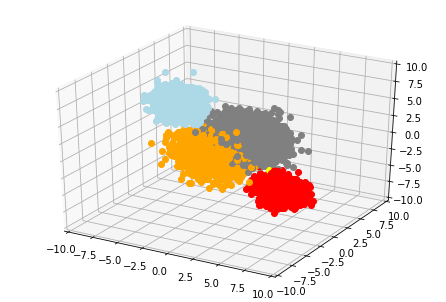

In [4]:
np.savetxt("z.csv", gamma, delimiter=",")
with open("params.dat", "w") as f:
    f.write("alpha:\n")
    for k in range(vb.n_cluster):
        f.write("cluster %d: %s\n" % (k, vb.alpha[k]))
    f.write("m:\n")
    for k in range(vb.n_cluster):
        f.write("cluster %d: %s\n" % (k, vb.m[:, k]))
    f.write("W:\n")
    for k in range(vb.n_cluster):
        f.write("cluster %d:\n%s\n" % (k, vb.W[:, :, k]))
    f.write("nu\n")
    for k in range(vb.n_cluster):
        f.write("cluster %d: %s\n" % (k, vb.nu[k]))
    f.write("beta:\n")
    for k in range(vb.n_cluster):
        f.write("cluster %d: %s\n" % (k, vb.beta[k]))
with open("vblikelihood.txt", "w") as f:
    f.write("iter\tlower bound\n")
    for i in range(len(record)):
        f.write("%d\t%f\n" % (record[i, 0], record[i, 1]))

# plot
labels = np.argmax(gamma, axis=1)
colors = ["red", "lightblue", "lightgreen", "orange", "yellow", "gray"]
label_color = [colors[int(label)] for label in labels]
fig = plt.figure()
ax = Axes3D(fig)
for i in range(X.shape[0]):
    ax.plot([X[i, 0]], [X[i, 1]], [X[i, 2]], "o", color=label_color[i])
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)
    ax.set_zlim(-10, 10)
plt.savefig("vb.png")
plt.show()
plt.close()